# Uncapacitated Facility Location Problem

## Load the data

In [1]:
#### Loading the data
import os
import pandas as pd  # type: ignore

# Parameters

#### food demand ####
food_per_person = 1.3 / 1000  # Tons per person

#### transportation costs ####
transportation_cost = 3364 / 10.5  # COP per ton per km

#### facility costs ####
### renting a warehouse
warehouse_cost_per_m2 = 24450 / 4  # COP/semana
### How much space is needed per ton of food
space_per_ton = 10.5 / 7.8 * 1.1  # ton per m2

# path to the data
data_path = "data"
municipios_filename = "municipios_procesado.csv"
distance_matrix_filename = "distance_matrix_final.csv"
# load the data
population = pd.read_csv(
    os.path.join(data_path, municipios_filename),
    usecols=[
        "departamento",
        "municipio",
        "c_digo_dane_del_departamento",
        "dpmp",
        "2024",
        "lat",
        "lon",
    ],
)
distance_matrix = (
    pd.read_csv(os.path.join(data_path, distance_matrix_filename), index_col="dpmp")
    / 1000
)  # convert to km
n = 185  # number of municipalities to consider
population = population.sample(n)
distance_matrix = distance_matrix.sample(n, axis=0).sample(n, axis=1)
# calculate the population per department = sum of the population of the municipalities in the department placed for each municipality in the department
population_per_department = population.groupby("c_digo_dane_del_departamento").sum()
population["population_per_department"] = population[
    "c_digo_dane_del_departamento"
].map(population_per_department["2024"])


<Axes: >

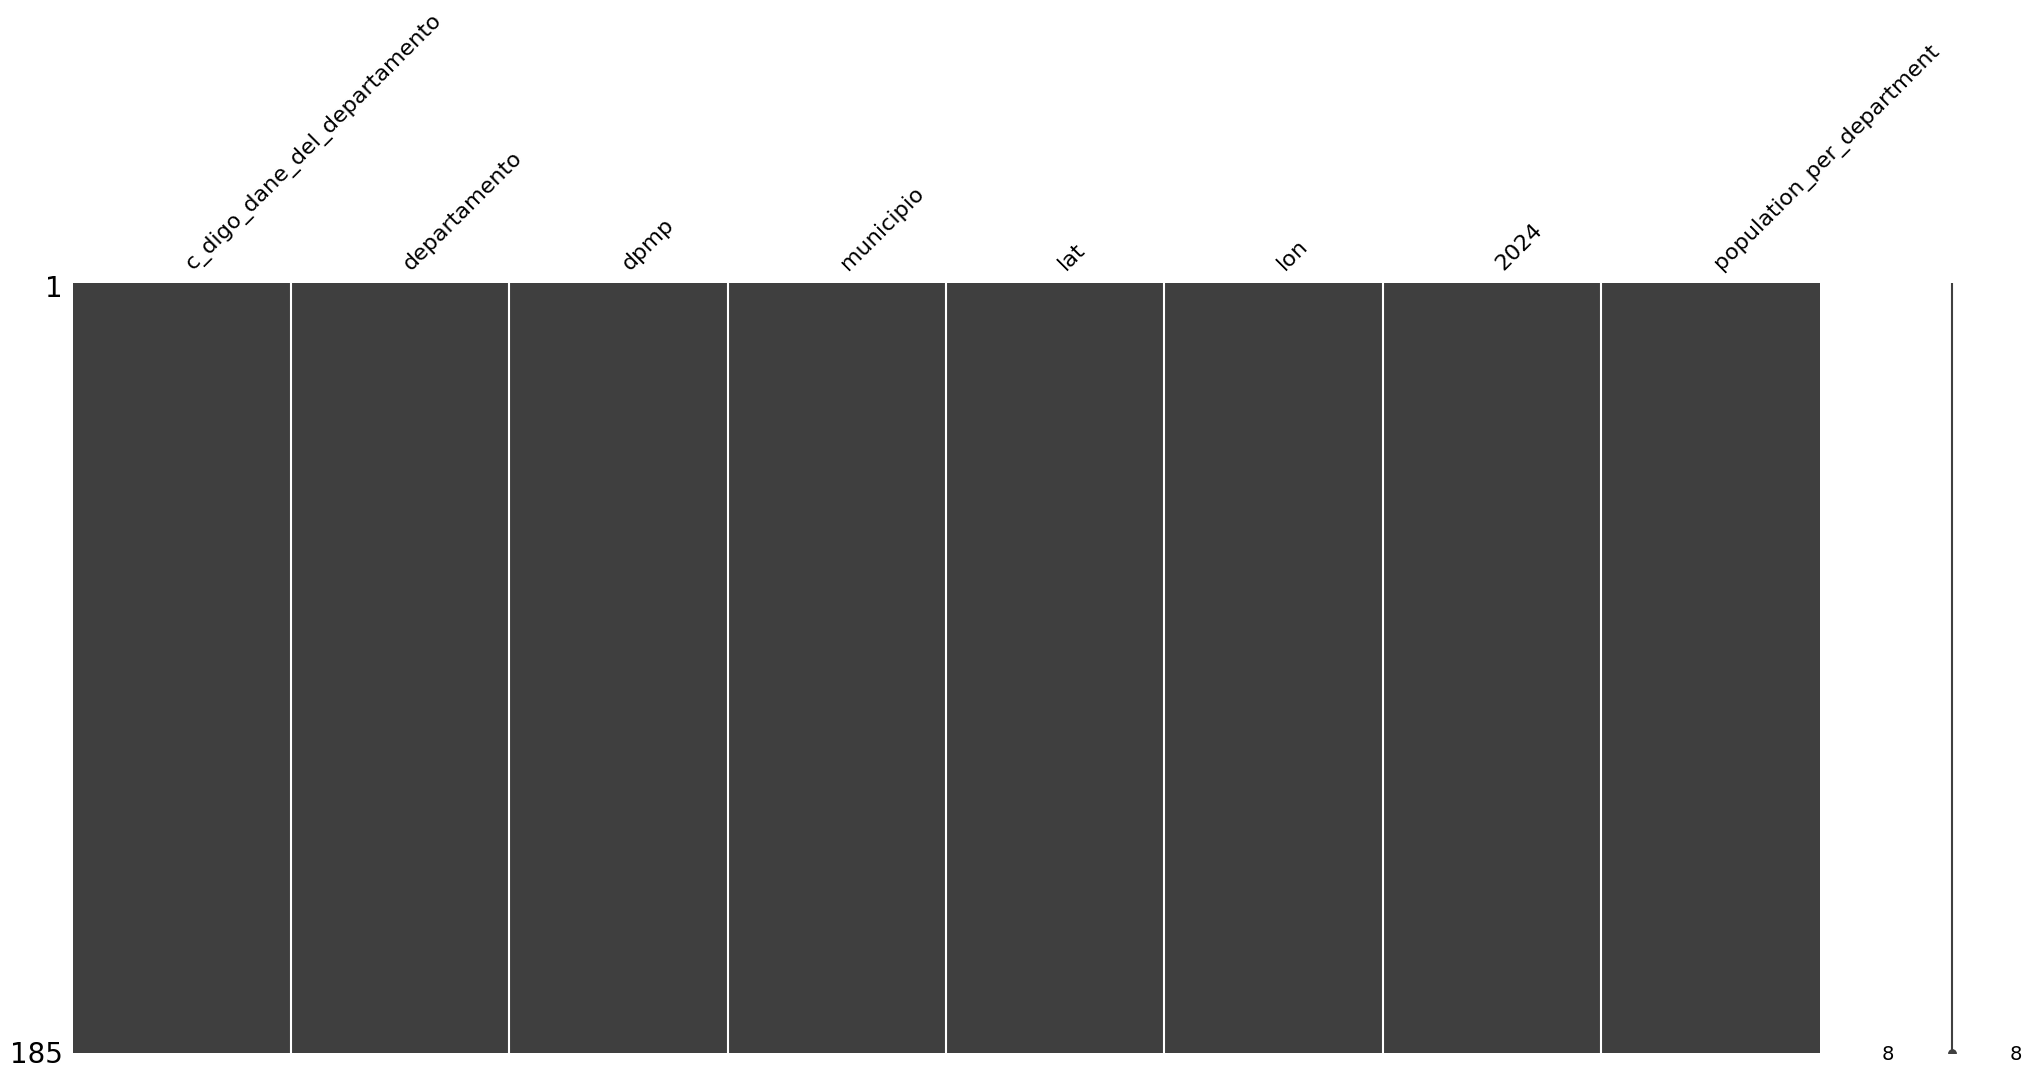

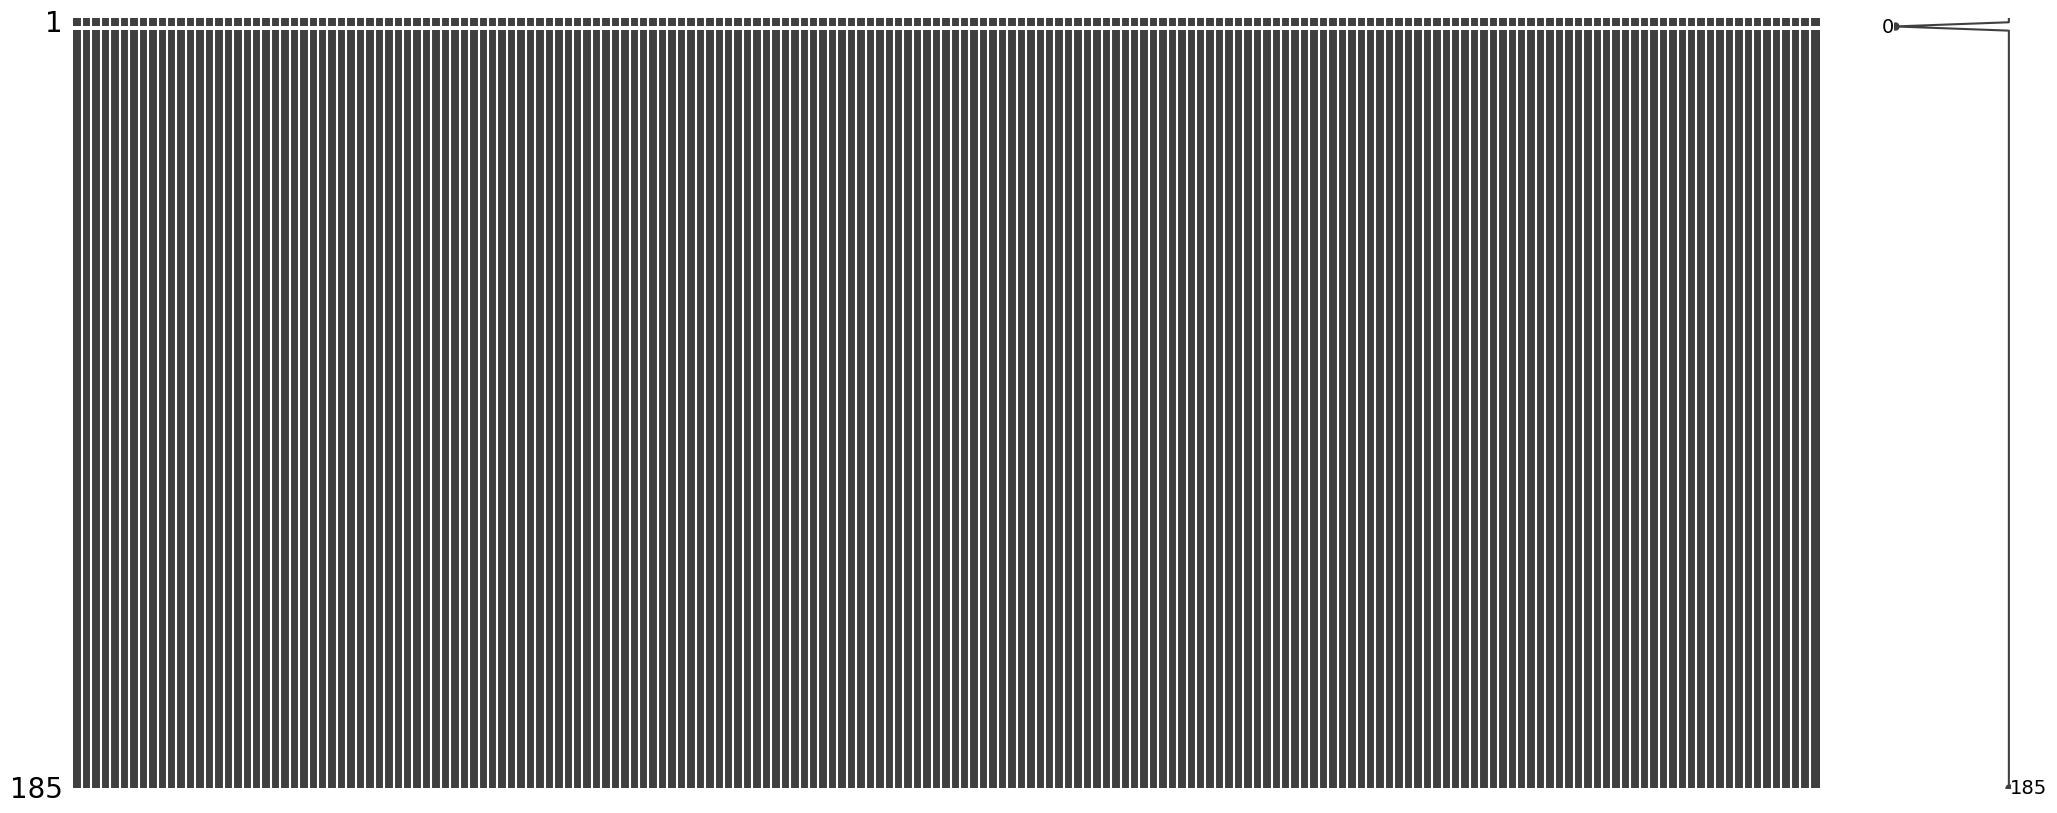

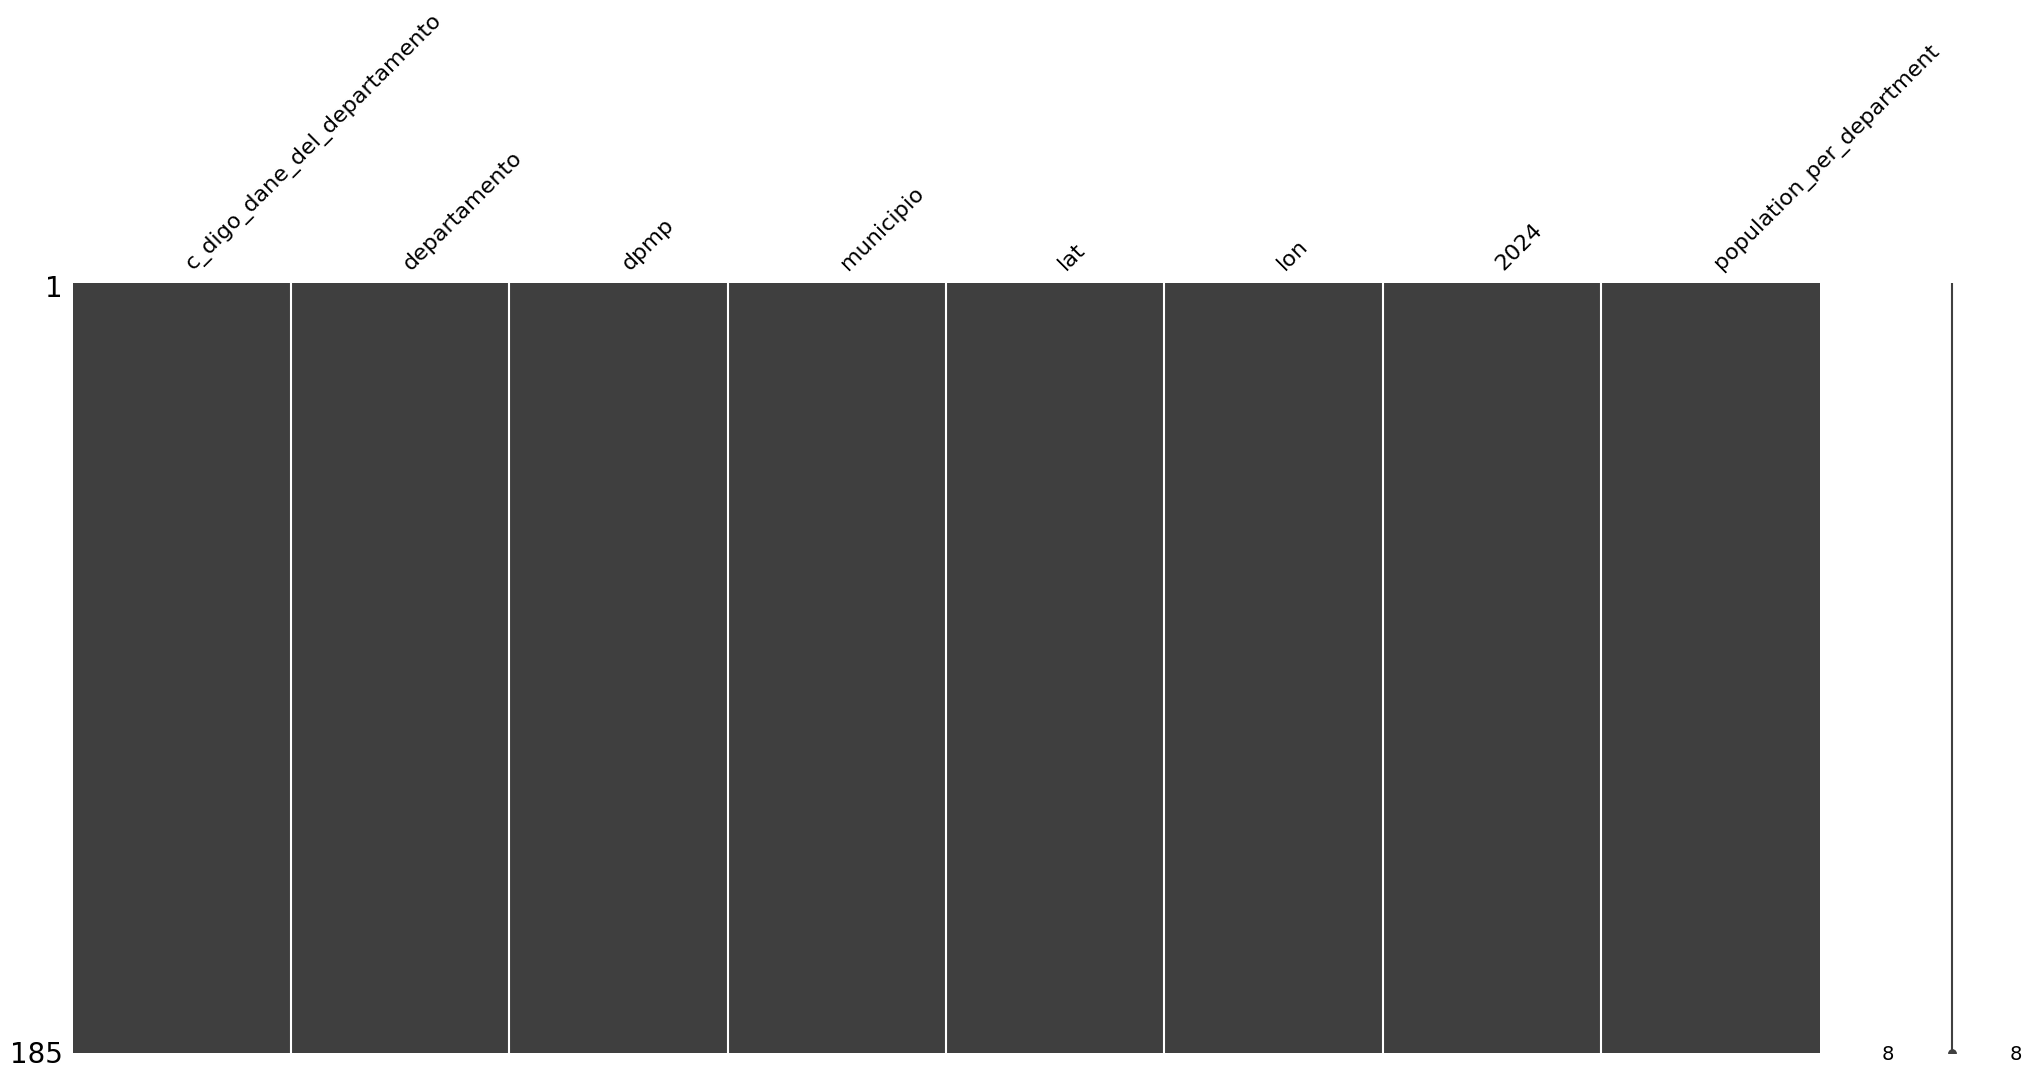

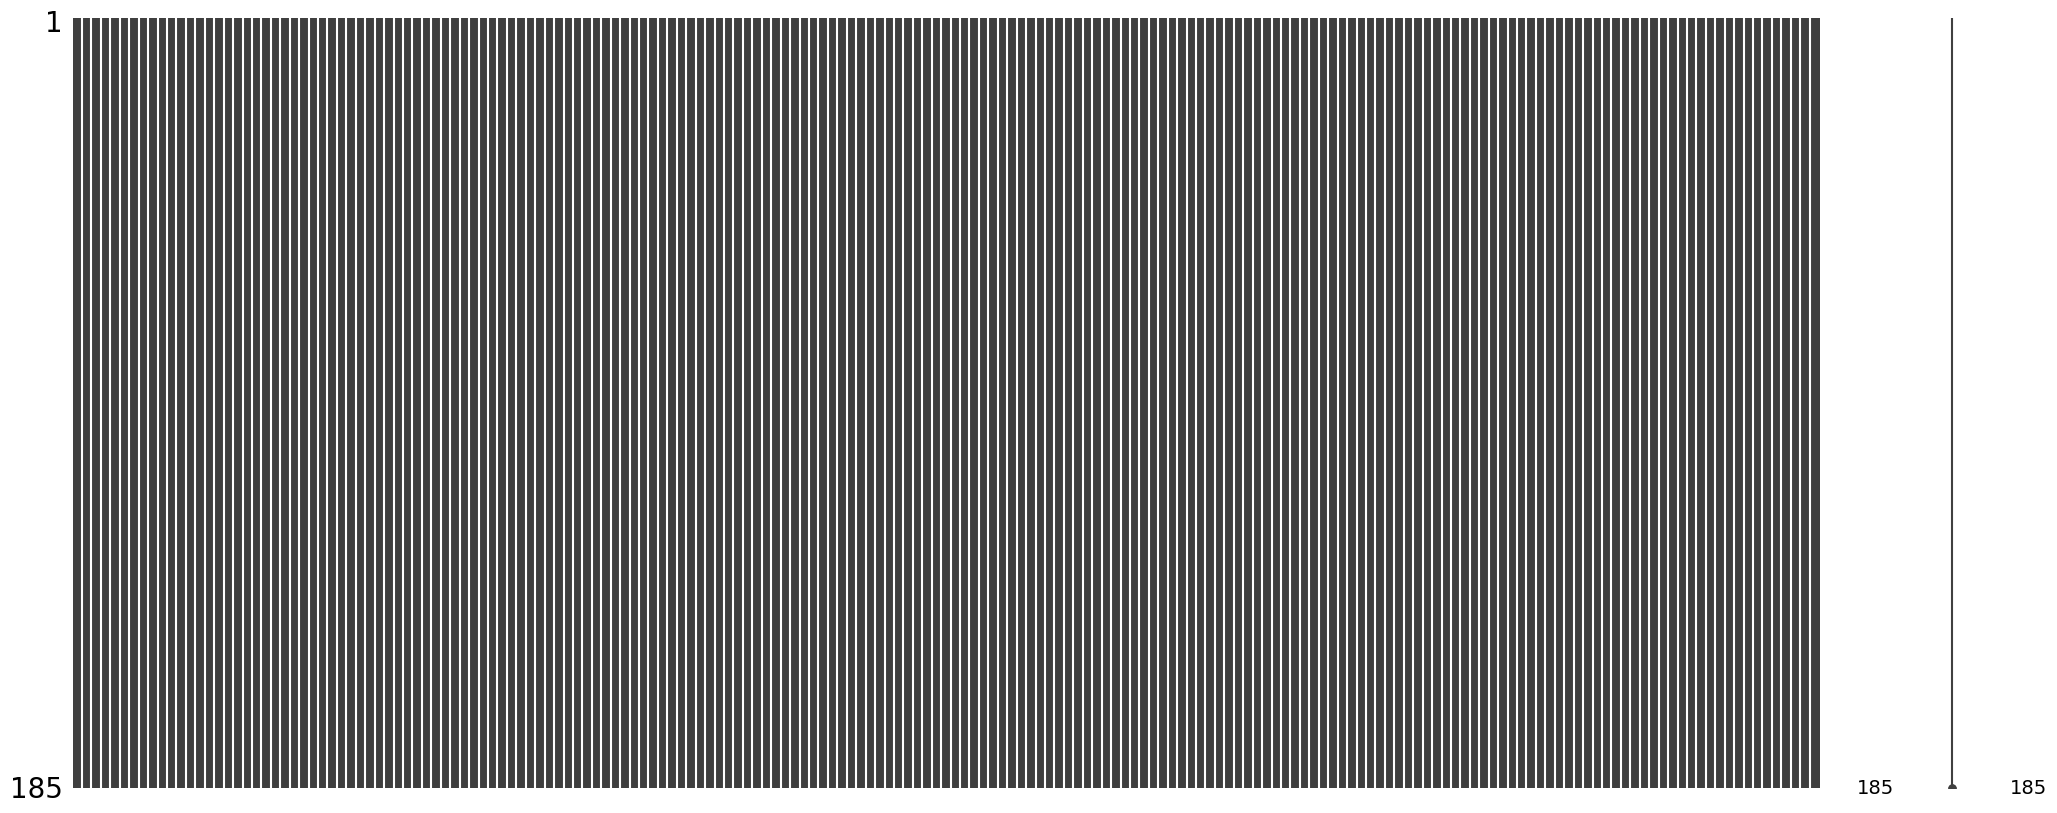

In [2]:
# Check for missing values
import missingno as msno  # type: ignore

msno.matrix(population)
msno.matrix(distance_matrix)
# for population, fill all nan values with 0
population.fillna(0, inplace=True)
# for distance matrix, fill all nan values with the maximum value * 100
distance_matrix.fillna(distance_matrix.max().max() * 100, inplace=True)
msno.matrix(population)
msno.matrix(distance_matrix)


## Load the Model

In [3]:
import sys


sys.path.append("..")


from lp.cflp import CFLP



# h_i: demand of food in municipality i


h = population["2024"] * food_per_person


# c_ij: cost of transporting food from municipality i to j


c = distance_matrix * transportation_cost


# f_j: cost of building a warehouse in municipality j warehouse_cost_per_m2 * space_per_ton * department_demand


f = (
    warehouse_cost_per_m2
    * space_per_ton
    * population["population_per_department"]
    * food_per_person
)


# v_j: maximum capacity of facility j


v = population["population_per_department"] * food_per_person

h.to_csv("cflp_demand.csv")
c.to_csv("cflp_cost.csv")



f.to_csv("cflp_facilityCost.csv")


v.to_csv("cflp_capacity.csv")



# Turn the data to lists
h = h.tolist()
c = c.values.tolist()
f = f.tolist()
v = v.tolist()



cflp = CFLP(h_i=h, c_ij=c, f_j=f, v_j=v)
cflp.load_to_pulp()


## Solve the problem

In [ ]:
#### Solving the problem
from pulp import PULP_CBC_CMD  # type: ignore

# Solve the problem showing the log
cflp.pulp_model.solve(PULP_CBC_CMD(msg=True))
# print(cflp.pulp_model.objective.value())
# print(cflp.pulp_model.status)


In [ ]:
#### Save the results
solution = cflp.get_solution_by_pulp()
x = solution["x"]
y = solution["y"]

# X to dataframe
x_df = pd.DataFrame(x, index=[0]).transpose().rename(columns={0: "x"})
# Y to dataframe
max_index_0 = max(key[0] for key in y.keys())
max_index_1 = max(key[1] for key in y.keys())
y_df = pd.DataFrame(index=range(max_index_0 + 1), columns=range(max_index_1 + 1))
for key, value in y.items():
    y_df.at[key[0], key[1]] = value

# change index and column values to the dpmp of population
x_df.index = population["dpmp"]  # type: ignore
y_df.index = population["dpmp"]  # type: ignore
y_df.columns = population["dpmp"]

solution_combined = pd.concat([x_df, y_df], axis=1)
solution_combined.to_csv("cflp-solution.csv")


## Display the data

In [ ]:
#### Plotting the solution
# The data for the position of the municipalities is in population dataframe
# which municipalities are meant to have a warehouse are the ones with x = 1
# Finally, the value of y_ij is the percentage of food that is going from i to j
# The map must be scoped to the country of Colombia
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd

fig = px.scatter_mapbox(
    population,
    lat="lat",
    lon="lon",
    hover_name="municipio",
    hover_data=["2024"],
    color="2024",
    size="2024",
    color_continuous_scale=px.colors.sequential.Plasma,
    zoom=4,
    height=600,
)

# add the lines
for i in range(len(y_df.index)):
    for j in range(len(y_df.columns)):
        if float(y_df.iloc[i, j]) > 0 and i != j:
            fig.add_trace(
                go.Scattermapbox(
                    lat=[population.iloc[i]["lat"], population.iloc[j]["lat"]],
                    lon=[population.iloc[i]["lon"], population.iloc[j]["lon"]],
                    mode="lines",
                    line=go.scattermapbox.Line(
                        width=float(y_df.iloc[i, j]) * 2,
                        color="blue",
                    ),
                    hoverinfo="text",
                    text=f'{population.iloc[i]["municipio"]} -> {population.iloc[j]["municipio"]}: {float(y_df.iloc[i, j]) * 100:.2f}%',
                )
            )

# add the warehouses
warehouses = population[
    population["dpmp"].isin(solution_combined[solution_combined["x"] == 1].index)
]
fig.add_trace(
    go.Scattermapbox(
        lat=warehouses["lat"],
        lon=warehouses["lon"],
        mode="markers",
        marker=go.scattermapbox.Marker(size=10, color="rgb(255, 0, 0)", opacity=0.7),
        hoverinfo="text",
        text=warehouses["municipio"],
    )
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.show()
# save the figure
fig.write_html("cflp-solution.html")

# Open the html file
import webbrowser

webbrowser.open_new_tab("cflp-solution.html")


True

## END